<a href="https://colab.research.google.com/github/IntroComputationalPhysics-UNT/kapitza-pendulum-firebats2000/blob/main/kapitza_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Psuedocode

##1. Define dimensionlesss equation of motion:
* $\theta''+ 2\zeta\theta' + (\epsilon^2 - \alpha cos\tau)sin\theta = 0$
* $\tau = \omega_d t$

## 2. Define the ODE system (RHS function):
* Input: $\tau$, state vector $y = [\theta, \theta'], parameters (\epsilon, \alpha, \zeta)$
* Output: derivatives $[\theta',\theta'']$
* function kapitza_rhs($\tau, y, \epsilon, \alpha, \zeta$):
  * $\theta = y[0]$
  * $\theta' = y[1]$
  * $\theta'' = -2\zeta\theta' - (\epsilon^2 - \alpha cos(\tau))sin(\theta)$
* return [$\theta', \theta''$]

## 3.  Integrate using solve_ivp:
* sol = solve_ivp(kapitza_rhs, t_span = (0, tau_end), y0 = [theta0, theta_dot0], t_eval = tau_eval, args = (eps, alpha, zeta))
* Extarct $\theta(t)$: $\theta = sol.y[0]$
* Deiscard tansient portion:
  * index_start = index corresponding to N_periods_discard
  * theta_ss = theta[index_start:]
* compute stability measure

## 4.  Parameter sweep over $(\epsilon, \alpha)$
* eps_vals = array of $\epsilon$ values
* alpha_vals = array of $\alpha$ values
* create 2D array S to store diagnostics: S = zeros((len(alpha_vals), len(eps_vals)))

## 5.  Extract approximate stability boundry $\alpha_c(\epsilon)$
* alpha_c = array of lenght(eps_cals)
* For each epsilon index j:
  * column = S[:, j]
  * find first $\alpha_i$ where diagnostic < threshhold
  * if found: alpha_c[j] = alpha_vals[i]
  * else: alpha_c[j] = NaN

## 6.  Fit $\alpha_c = C\epsilon^2$
* valid_indices = where(alpha_c is finite)
* C= mean(alpha_c[valid]/(eps_vals[valid]^2))

## 7.  Plot 2D stability map
* Use matplotlib imshow or pcolormesh:
  * x-axis = $\epsilon$
  * y-axis = $\alpha$
  * color = diagnostic S[i, j]
* overlay fitted stability curve:
  * $\alpha_{fit}(\epsilon) = C\epsilon^2$
  * plot $\epsilon$ vs $\alpha_{fit}$

## 8. Print summary:
* Print fitted constant c
* Print $\alpha_c(\epsilon)$ table
* Print comments on stable vs unstable regions

In [ ]:
# Packages installation

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define ODE (right hand side)
def kapitza_rhs(tau, y, eps, alpha, zeta):
    theta, theta_dot = y
    dtheta_dt = theta_dot
    dtheta_dot_dt = -2*zeta*theta_dot - (eps**2 - alpha*np.cos(tau))*np.sin(theta)
    return [dtheta_dt, dtheta_dot_dt]

    #tau: Dimensionless time, tau = omega_d * t.
    #y: State vector [theta, theta_dot], where theta is the pendulum angle (theta = pi is inverted), theta_dot = dtheta/dtau.
    #eps: Dimensionless natural frequency, eps = omega_0 / omega_d.
    #alpha: Dimensionless drive amplitude, alpha = y0 / l.
    #zeta: Dimensionless damping coefficient, zeta = gamma / omega_d.

In [ ]:
# Stability diagnostic

def compute_stability(eps, alpha, zeta,
                      theta0=np.pi + 1e-3,
                      theta_dot0=0,
                      N_periods_total=100,    #changed to a more reasonable N count
                      N_periods_discard=50,
                      points_per_period=100,
                      delta_theta_crit=0.3):   #for bound osciallation

    # integration time
    tau_end = N_periods_total * 2*np.pi
    tau_eval = np.linspace(0, tau_end,
                           N_periods_total * points_per_period)

    sol = solve_ivp(
        kapitza_rhs,
        (0, tau_end),
        [theta0, theta_dot0],
        t_eval=tau_eval,
        args=(eps, alpha, zeta),
        rtol=1e-7,
        atol=1e-9
    )

    thetas = sol.y[0]

    # discard transients
    discard_idx = int(len(tau_eval) *
                      (N_periods_discard / N_periods_total))
    thetas_ss = thetas[discard_idx:]

    # diagnostic = std deviation of θ around π
    diag = np.max(np.abs(thetas_ss - np.pi))
    is_stable = diag < delta_theta_crit

    return diag, is_stable

In [ ]:
# Parameter sweep

# Example sweep ranges
eps_vals  = np.linspace(0.5, 2.0, 10)
alpha_vals = np.linspace(0, 10, 80)


zeta = 0.05  # fixed damping

# Storage array
S = np.zeros((len(alpha_vals), len(eps_vals)))
stable_mask = np.zeros_like(S, dtype=bool)

for i, alpha in enumerate(alpha_vals):
    for j, eps in enumerate(eps_vals):
        diag, is_stable = compute_stability(eps, alpha, zeta)
        S[i, j] = diag
        stable_mask[i, j] = is_stable

print("Sweep complete.")

Sweep complete.


In [ ]:
# Exract stability boundary alpha_c(epsilon)

threshold = 0.1  # stability threshold for std(theta - π)

alpha_c = np.full(len(eps_vals), np.nan)

for j, eps in enumerate(eps_vals):
    col = S[:, j]
    stable_indices = np.where(col < threshold)[0]
    if len(stable_indices) > 0:
        alpha_c[j] = alpha_vals[stable_indices[0]]

# Fit α_c ≈ C ε²
mask = np.isfinite(alpha_c)
C_fit = np.mean(alpha_c[mask] / (eps_vals[mask]**2))

print(f"Fitted coefficient C ≈ {C_fit:.4f}")

Fitted coefficient C ≈ 2.5633


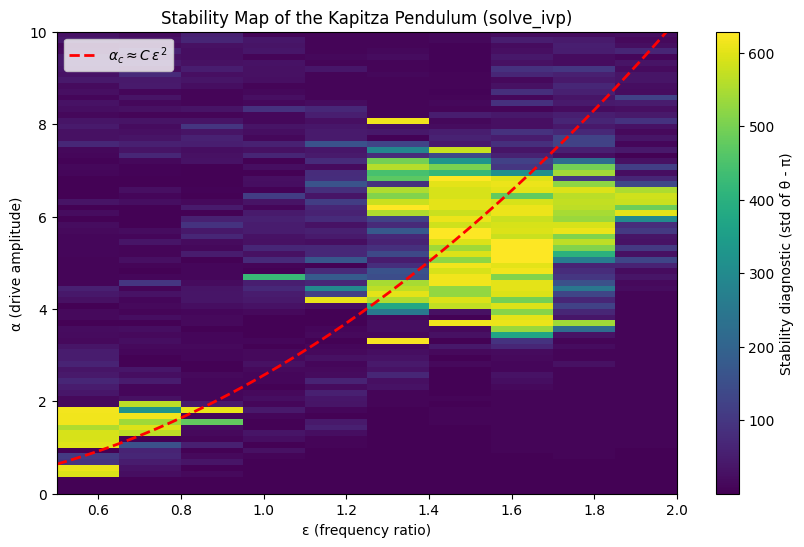

In [ ]:
# 2D stability map

plt.figure(figsize=(10,6))
plt.imshow(S,
           extent=[eps_vals.min(), eps_vals.max(),
                   alpha_vals.max(), alpha_vals.min()],
           aspect='auto',
           cmap='viridis')
plt.colorbar(label="Stability diagnostic (std of θ - π)")
plt.ylim(alpha_vals.min(), alpha_vals.max())    #Added in order have y-axis alpha rise upward


plt.xlabel("ε (frequency ratio)")
plt.ylabel("α (drive amplitude)")
plt.title("Stability Map of the Kapitza Pendulum (solve_ivp)")

# Overlay fitted α_c curve
eps_curve = np.linspace(eps_vals.min(), eps_vals.max(), 200)
alpha_curve = C_fit * eps_curve**2

plt.plot(eps_curve, alpha_curve, 'r--', lw=2, label=r"$\alpha_c \approx C\,\epsilon^2$")
plt.legend()

plt.show()

In [ ]:
# Print summary

print("\nStability boundary:")
for eps, ac in zip(eps_vals, alpha_c):
    print(f"ε = {eps:.2f} → α_c ≈ {ac:.3f}")


Stability boundary:
ε = 0.50 → α_c ≈ nan
ε = 0.67 → α_c ≈ 1.139
ε = 0.83 → α_c ≈ nan
ε = 1.00 → α_c ≈ nan
ε = 1.17 → α_c ≈ nan
ε = 1.33 → α_c ≈ nan
ε = 1.50 → α_c ≈ nan
ε = 1.67 → α_c ≈ nan
ε = 1.83 → α_c ≈ nan
ε = 2.00 → α_c ≈ nan


# Summary

## Stability criterion:
After integrating the system with solve_ivp, I discard an initial transient and measure the *standard deviation* of $\theta-pi$ over the remaining time.
* Small deviation - inverted state stays near $\pi$, *stable*.
* Large deviation - the pendulum departs form $\pi$, *unstable*.

## Numerical choices:
Integrated over a few hundred drive periods, discard the early part, and analyze the final portion to capture long-time behavior. The time grid uses enough points per period to resolve the fast drive. The $(\epsilon, \alpha)$ grid is chosen to cover the typical stabilization regime. A threshold like std < 0.1 cleanly separates stable and unstable cases.

## Boundary fuctional form:
Classical averaging theory predicts that stabilization requires $\alpha_c(\epsilon)$ proportional to $\epsilon^2$. So I fit the numerical boundary to $\alpha_c = C\epsilon^2$.

## Fit quality:
This quadratic form matches the numerical stability boundary well at moderate and large $\epsilon$, where the high-frequency approximation is valid. Deviations at lower $\epsilon$ are expected.